# Model Building


In [3]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Path to the dataset
dataset_path = r"C:\Users\hidde\OneDrive\Documents\FaceExpressions\Selected_data\train"

# Listing the folders of different classes
classes = os.listdir(dataset_path)

data = []
for label in classes:
    class_path = os.path.join(dataset_path, label)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        data.append([img_path, label])

data = pd.DataFrame(data, columns=['full_path', 'label'])

# Sampling 512 images from each category
data_sampled = data.groupby('label').apply(lambda x: x.sample(512, random_state=43)).reset_index(drop=True)

# Image preprocessing function
def read_image(path, image_size=(128, 128)):
    img = Image.open(path).resize(image_size)
    img = np.asarray(img)
    img = (img - 127.5) / 127.5  # Normalize to [-1, 1]
    return img

# Apply preprocessing
data_sampled['image'] = data_sampled['full_path'].apply(read_image)

# Convert DataFrame to TensorFlow dataset
def df_to_tf_dataset(dataframe, image_size=(128, 128), batch_size=32):
    images = np.array(dataframe['image'].tolist())
    labels = pd.get_dummies(dataframe['label']).values
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Split data into training and validation sets
train_data = data_sampled.sample(frac=0.8, random_state=42)
val_data = data_sampled.drop(train_data.index)

train_dataset = df_to_tf_dataset(train_data)
val_dataset = df_to_tf_dataset(val_data)

# Load VGG16 model without the top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(6, activation='softmax')(x)  # Number of classes

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


## Feature extraction

In [4]:



# Train the model
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset#,
    #callbacks=[checkpoint, early_stopping]
)


Epoch 1/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.3228 - loss: 1.8228 - val_accuracy: 0.4544 - val_loss: 1.2767
Epoch 2/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.4684 - loss: 1.2958 - val_accuracy: 0.5081 - val_loss: 1.1915
Epoch 3/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.5465 - loss: 1.1406 - val_accuracy: 0.5619 - val_loss: 1.0933
Epoch 4/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.5938 - loss: 1.0325 - val_accuracy: 0.5863 - val_loss: 1.0479
Epoch 5/5
77/77 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6237 - loss: 0.9373 - val_accuracy: 0.6140 - val_loss: 0.9934


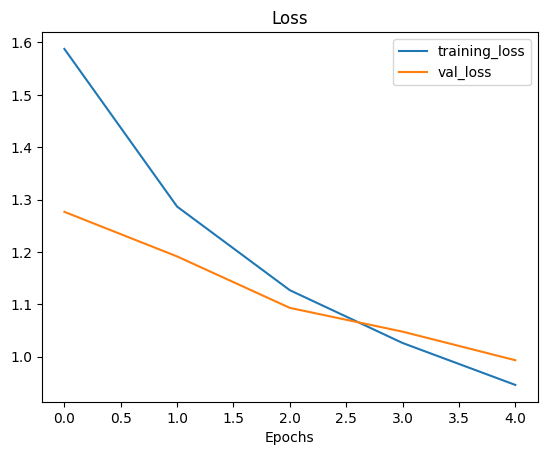

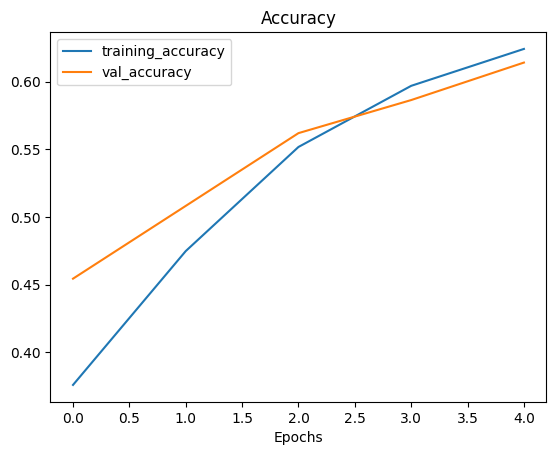

In [7]:
plot_loss_curves(history)

## Fine Tuning

In [8]:

# Unfreeze some of the top layers
for layer in base_model.layers:
    layer.trainable = False  # Initially freeze all layers

# Unfreeze the last few layers of the base model
for layer in base_model.layers[-5:]:  # Adjust the number of layers to unfreeze
    layer.trainable = True


In [9]:

# Recompile the model after modifying the layer's trainable property
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
# Fine tune for another 5 epochs
initial_epochs=history.epoch[-1]
fine_tune_epochs = initial_epochs +6
# refit the model(same as feature extracted model except with the more trainable layers)
history_finetuned = model.fit(
    train_dataset,
    epochs = fine_tune_epochs,
    validation_data=val_dataset,
    initial_epoch=history.epoch[-1]
    #callbacks=[checkpoint, early_stopping]
)

Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.6838 - loss: 0.8739 - val_accuracy: 0.6482 - val_loss: 0.9352
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.7618 - loss: 0.6570 - val_accuracy: 0.6107 - val_loss: 0.9421
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.7948 - loss: 0.5507 - val_accuracy: 0.6906 - val_loss: 0.8000
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 172s 2s/step - accuracy: 0.8321 - loss: 0.4470 - val_accuracy: 0.7166 - val_loss: 0.8199
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 158s 2s/step - accuracy: 0.8789 - loss: 0.2982 - val_accuracy: 0.6906 - val_loss: 0.9395
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 159s 2s/step - accuracy: 0.9043 - loss: 0.2866 - val_accuracy: 0.7280 - val_loss: 0.9610


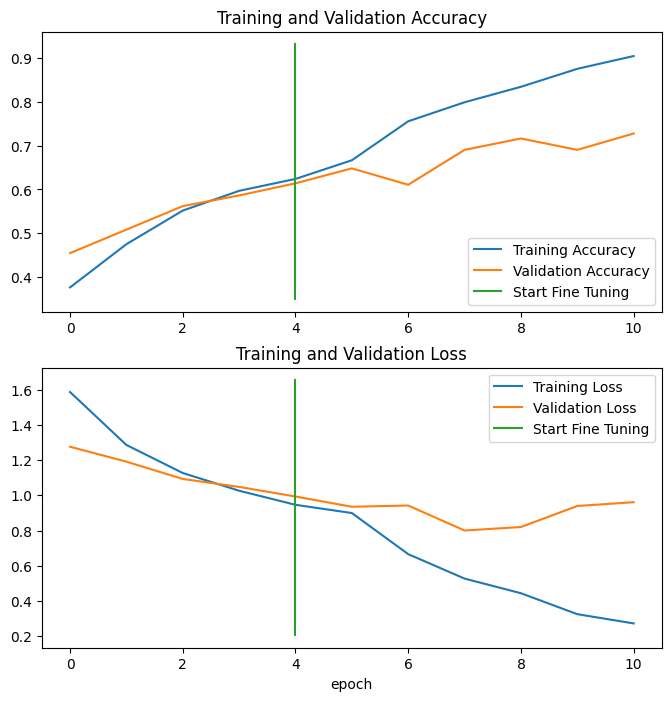

In [12]:
compare_historys (history,history_finetuned,5)

In [15]:
from keras.models import save_model
save_model(model, 'C:/Users/hidde/OneDrive/Documents/FaceExpressions/VGG_finetuned.keras')

# extra features


In [ ]:

def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two TensorFlow model History objects.
    
    Args:
      original_history: History object from original model (before new_history)
      new_history: History object from continued model training (after original_history)
      initial_epochs: Number of epochs in original_history (new_history plot starts from here) 
    """
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()
  

In [6]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();